In [2]:
%pip install pyspark
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 MB 8.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)
  DEPRECATION: pyspark is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  Running setup.py install for pyspark ... done

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 48.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 84.7 MB/s 

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, count, col, mean, min, max
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
from pyspark.sql.functions import regexp_extract, col, regexp_replace, avg, sum
import matplotlib.pyplot as plt

# Initialize SparkSession
spark = (SparkSession.builder
                    .appName("Proyecto_Final_Procesamiento_de_Datos")
                    .getOrCreate()
        )

25/03/06 22:40:24 WARN Utils: Your hostname, Armandos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.131 instead (on interface en0)
25/03/06 22:40:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/06 22:40:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
# Definiendo el esquema inicial con los tipos de datos adecuados (String) y el manejo de los datos entre comillas
schema = StructType([
    StructField("Title", StringType(), True),
    StructField("Sumary", StringType(), True),
    StructField("Director", StringType(), True),
    StructField("Writer", StringType(), True),
    StructField("Main_Genres", StringType(), True),
    StructField("Motion_Picture_Rating", StringType(), True),
    StructField("Runtime_Minutes", IntegerType(), True),
    StructField("Release_Year", StringType(), True),
    StructField("Rating", StringType(), True),
    StructField("Number_of_Ratings", StringType(), True),
    StructField("Budget", StringType(), True),
    StructField("Gross_US_Canada", StringType(), True),
    StructField("Gross_Worldwide", StringType(), True),
    StructField("Opening_Weekend_US_Canada", StringType(), True)
])

# Cargando los datos de IMDbMovies.csv en la carpeta "01_capa_inicial", la misma que debemos crear,
#utilizando el esquema especificado "schema" y el manejo de cadenas entre comillas
df = spark.read.csv("content/01_capa_inicial/IMDbMovies.csv", header=True, schema=schema, quote='"', escape='"')

# Mostrando las primeras filas del DataFrame
df.show(10)

AnalysisException: [PATH_NOT_FOUND] Path does not exist: file:/01_capa_inicial/IMDbMovies.csv.

In [41]:
# Definiendo los esquemas para migrar la data
months_abbr = r"(Ene|Feb|Mar|Abr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dic)"

finanzas_cleaned_df = (df
    .withColumn("Currency",regexp_extract(col("Budget"), "(?:[\$€£¥]|\b(?:USD|EUR|GBP|MXN)\b)", 0))
    .withColumn("Budget", regexp_replace(col("Budget"), r"[^0-9.]", ""))
    .withColumn("Budget", when(col("budget") == "", None).otherwise(col("budget").cast("double")))
    .withColumn("Gross_US_Canada", regexp_replace(col("Gross_US_Canada"), "[$,]", ""))
    .withColumn("Gross_US_Canada", when(col("Gross_US_Canada") == "", None).otherwise(col("Gross_US_Canada").cast("double")))
    .withColumn("Gross_Worldwide", regexp_replace(col("Gross_Worldwide"), "[$,]", ""))
    .withColumn("Gross_Worldwide", when(col("Gross_Worldwide") == "", None).otherwise(col("Gross_Worldwide").cast("double")))
    .withColumn("Opening_Weekend_US_Canada", regexp_extract(col("Opening_Weekend_US_Canada"), r"^(.*?)(" + months_abbr + r")", 1))
    .withColumn("Opening_Weekend_US_Canada", regexp_replace(col("Opening_Weekend_US_Canada"), "[$,]", ""))
    .withColumn("Opening_Weekend_US_Canada", when(col("Opening_Weekend_US_Canada") == "", None).otherwise(col("Opening_Weekend_US_Canada").cast("double")))
    .select("Title", "Release_Year", "Currency", "Budget", "Gross_US_Canada", "Gross_Worldwide", "Opening_Weekend_US_Canada"))

#Imprimimos el esquema
finanzas_cleaned_df.printSchema()

#Imprimimos el DataFrame
print(finanzas_cleaned_df)

#Mostramos registros
finanzas_cleaned_df.show(10)

# Guardamos en formato Parquet la tabla de Finanzas
finanzas_cleaned_df.write.format("parquet").mode("overwrite").save("/content/02_capa_intermedia/finanzas.parquet")


root
 |-- Title: string (nullable = true)
 |-- Release_Year: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Budget: double (nullable = true)
 |-- Gross_US_Canada: double (nullable = true)
 |-- Gross_Worldwide: double (nullable = true)
 |-- Opening_Weekend_US_Canada: double (nullable = true)

DataFrame[Title: string, Release_Year: string, Currency: string, Budget: double, Gross_US_Canada: double, Gross_Worldwide: double, Opening_Weekend_US_Canada: double]
+--------------------+------------+--------+------+---------------+---------------+-------------------------+
|               Title|Release_Year|Currency|Budget|Gross_US_Canada|Gross_Worldwide|Opening_Weekend_US_Canada|
+--------------------+------------+--------+------+---------------+---------------+-------------------------+
|            Napoleon|        2023|    NULL|  NULL|    3.7514498E7|    8.4968381E7|              2.0638887E7|
|The Hunger Games:...|        2023|       $| 1.0E8|   1.05043414E8|   1.917292

In [43]:
# Creando el Dataframe de Calificaciones
calificaciones_cleaned_df = df.select(col("Title"), col("Release_Year").cast("int").alias("Release_Year"),
                                      regexp_replace(col("Rating"), "/10", "").cast("double").alias("Average_Rating"),
                                      when(col("Number_of_Ratings").contains("K"), regexp_replace(col("Number_of_Ratings"), "K", "").cast("integer") * 1000)
                                      .otherwise(regexp_replace(col("Number_of_Ratings"), "[^0-9]", "").cast("integer")).alias("Number_of_Ratings")
                                      )

# Imprimimos el schema
calificaciones_cleaned_df.printSchema()

# Muestra los primeros 10 resultados
calificaciones_cleaned_df.show(10)

# Guarda en formato parquet la tabla de Calificaciones
calificaciones_cleaned_df.write.format("parquet").mode("overwrite").save("/content/02_capa_intermedia/calificaciones.parquet")

root
 |-- Title: string (nullable = true)
 |-- Release_Year: integer (nullable = true)
 |-- Average_Rating: double (nullable = true)
 |-- Number_of_Ratings: integer (nullable = true)

+--------------------+------------+--------------+-----------------+
|               Title|Release_Year|Average_Rating|Number_of_Ratings|
+--------------------+------------+--------------+-----------------+
|            Napoleon|        2023|           6.7|            38000|
|The Hunger Games:...|        2023|           7.2|            37000|
|          The Killer|        2023|           6.8|           117000|
|                 Leo|        2023|           7.0|            10000|
|        Thanksgiving|        2023|           7.0|             9000|
|         Oppenheimer|        2023|           8.5|           525000|
|            Saltburn|        2023|           7.5|             7000|
|         The Marvels|        2023|           6.0|            57000|
|                Wish|        2023|           5.9|       


EDA Analisis para Finanzas:

Columna: Currency
+-------+--------+
|summary|Currency|
+-------+--------+
|  count|    5879|
|   mean|    NULL|
| stddev|    NULL|
|    min|        |
|    max|       €|
+-------+--------+

Valores faltantes: 3204
Cuenta de ceros: 0
Error en agregados númericos Currency: name 'isnan' is not defined
Cuenta valores distintos: 6
No es posible crear histograma para la columna Currency: no numeric data to plot

Columna: Budget
+-------+-------------------+
|summary|             Budget|
+-------+-------------------+
|  count|               5879|
|   mean|6.784311658989625E7|
| stddev| 7.10278383316229E8|
|    min|               30.0|
|    max|             3.0E10|
+-------+-------------------+

Valores faltantes: 3204
Cuenta de ceros: 0
Error en agregados númericos Budget: name 'isnan' is not defined
Cuenta valores distintos: 698


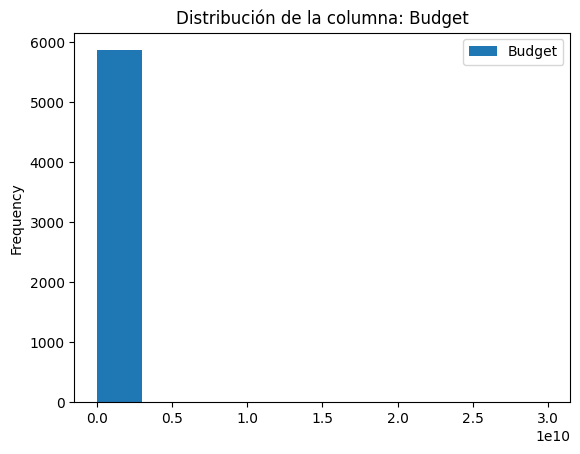


Columna: Gross_US_Canada
+-------+--------------------+
|summary|     Gross_US_Canada|
+-------+--------------------+
|  count|                6064|
|   mean|4.6809896366919525E7|
| stddev| 7.290609792266001E7|
|    min|                64.0|
|    max|        9.36662225E8|
+-------+--------------------+

Valores faltantes: 3019
Cuenta de ceros: 0
Error en agregados númericos Gross_US_Canada: name 'isnan' is not defined
Cuenta valores distintos: 6042


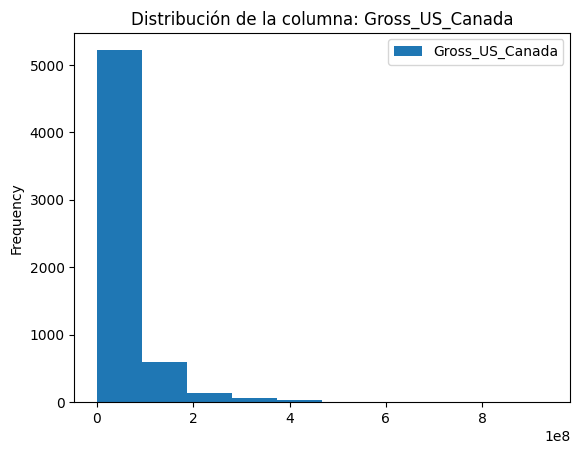


Columna: Gross_Worldwide
+-------+--------------------+
|summary|     Gross_Worldwide|
+-------+--------------------+
|  count|                7128|
|   mean|  8.71224586026936E7|
| stddev|1.7937874545864466E8|
|    min|                16.0|
|    max|       2.923706026E9|
+-------+--------------------+

Valores faltantes: 1955
Cuenta de ceros: 0
Error en agregados númericos Gross_Worldwide: name 'isnan' is not defined
Cuenta valores distintos: 7118


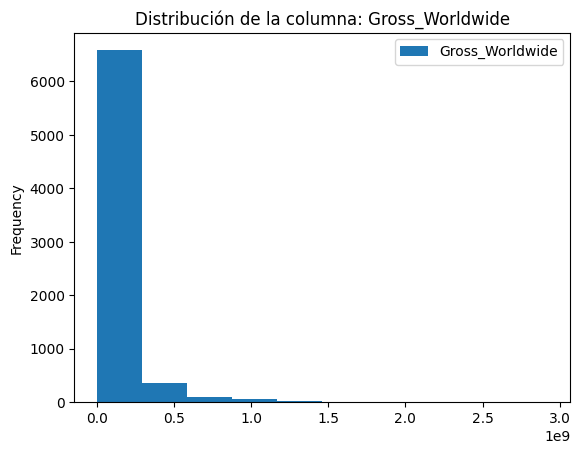


Columna: Opening_Weekend_US_Canada
+-------+-------------------------+
|summary|Opening_Weekend_US_Canada|
+-------+-------------------------+
|  count|                     4325|
|   mean|     1.3279344786820808E7|
| stddev|     2.2438454152121328E7|
|    min|                     63.0|
|    max|              2.0880627E8|
+-------+-------------------------+

Valores faltantes: 4758
Cuenta de ceros: 0
Error en agregados númericos Opening_Weekend_US_Canada: name 'isnan' is not defined
Cuenta valores distintos: 4307


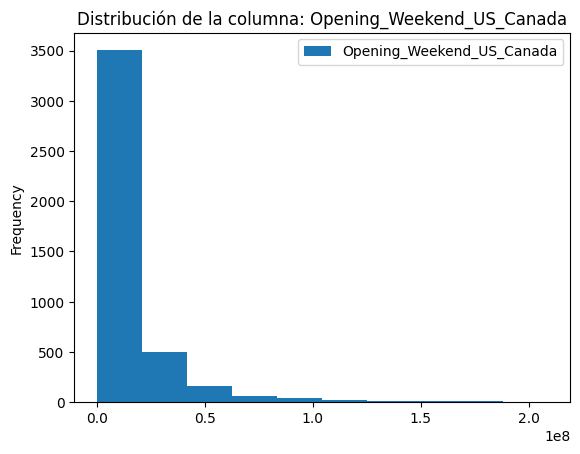


EDA Analisis para Calificaciones:

Columna: Average_Rating
+-------+-----------------+
|summary|   Average_Rating|
+-------+-----------------+
|  count|             8812|
|   mean|6.465966863368089|
| stddev|1.049738171349271|
|    min|              1.3|
|    max|             10.0|
+-------+-----------------+

Valores faltantes: 271
Cuenta de ceros: 0
Error en agregados númericos Average_Rating: name 'isnan' is not defined
Cuenta valores distintos: 82


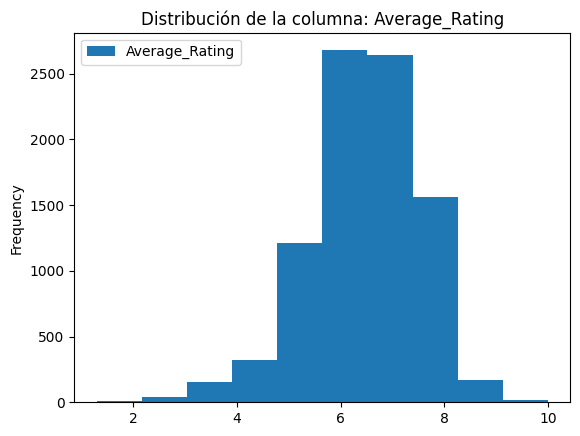


Columna: Number_of_Ratings
+-------+------------------+
|summary| Number_of_Ratings|
+-------+------------------+
|  count|              8813|
|   mean| 88658.52184273233|
| stddev|136177.43595423255|
|    min|                 1|
|    max|            975000|
+-------+------------------+

Valores faltantes: 270
Cuenta de ceros: 0
Error en agregados númericos Number_of_Ratings: name 'isnan' is not defined
Cuenta valores distintos: 1062


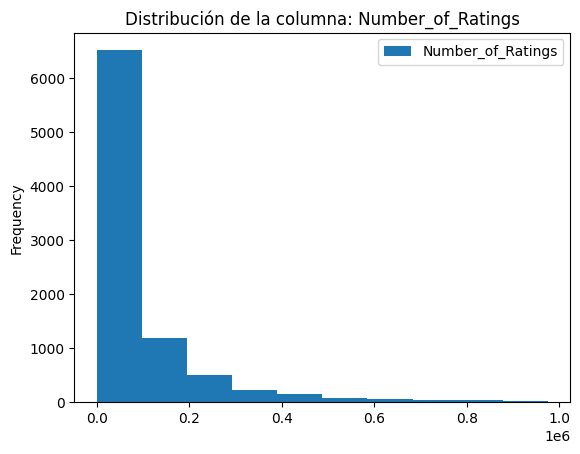

In [24]:
# Carga los archivos parquet
finanzas_cleaned_df = spark.read.parquet("/content/02_capa_intermedia/finanzas.parquet")
calificaciones_cleaned_df = spark.read.parquet("/content/02_capa_intermedia/calificaciones.parquet")

#Definimos nuestra función para realizar el análisis EDA (Análsis Exploratorio de Datos)
def analisis_eda(df, df_name):
  """
Realiza el análisis EDA de un dataFrame especifico.
  """
  print(f"\nEDA Analisis para {df_name}:")
  for column in df.columns:
      if column not in ["Title", "Release_Year"]: # Excluimos las columnas que son la clave para este análisis
          print(f"\nColumna: {column}")

          # Manejar de posibles errores de tipo para la agregados numéricos
          try:
              df.select(column).describe().show()
              print("Valores faltantes:", df.filter(col(column).isNull()).count())
              print("Cuenta de ceros:", df.filter(col(column) == 0).count())
              df.select(count(when(isnan(col(column)), column)).alias(f"cuenta_nulos_{column}")).show() # Cuenta de valores NaN

          except Exception as e:
              print(f"Error en agregados númericos {column}: {e}")

          # Cuenta valores distintos
          print("Cuenta valores distintos:", df.select(column).distinct().count())

          # Crea visualizaciones
          # En caso aplique para columnas Categoricas mostramos un gráfico de Barras
          # En caso aplique mostramos un Histograma para valores númericos
          try:
              df.select(column).toPandas().plot(kind='hist', title=f'Distribución de la columna: {column}')
              plt.show()

          except Exception as e:
              print(f"No es posible crear histograma para la columna {column}: {e}")


# Realiza Análisis EDA en el DataFrame de Finanzas
analisis_eda(finanzas_cleaned_df, "Finanzas")

# Realiza Análisis EDA en el DataFrame de Calificaciones
analisis_eda(calificaciones_cleaned_df, "Calificaciones")



In [44]:
# Agrupación por clave primaria y agregación
finanzas_grouped_df = (finanzas_cleaned_df
              .groupBy("Title", "Release_Year")
              .agg(
                  sum("Budget").alias("Total_Budget"),
                  sum("Gross_US_Canada").alias("Total_US_Canada_Gross"),
                  sum("Gross_Worldwide").alias("Total_Worldwide_Gross"),
                  sum("Opening_Weekend_US_Canada").alias("Total_Opening_Weekend_Gross")
              )
             )

# Mostrar los resultados
print(f"El número de registros de finanzas agrupados es: {finanzas_grouped_df.count()}")

finanzas_grouped_df.printSchema()
finanzas_grouped_df.show()


El número de registros de finanzas agrupados es: 9079
root
 |-- Title: string (nullable = true)
 |-- Release_Year: string (nullable = true)
 |-- Total_Budget: double (nullable = true)
 |-- Total_US_Canada_Gross: double (nullable = true)
 |-- Total_Worldwide_Gross: double (nullable = true)
 |-- Total_Opening_Weekend_Gross: double (nullable = true)

+--------------------+------------+------------+---------------------+---------------------+---------------------------+
|               Title|Release_Year|Total_Budget|Total_US_Canada_Gross|Total_Worldwide_Gross|Total_Opening_Weekend_Gross|
+--------------------+------------+------------+---------------------+---------------------+---------------------------+
|       Birds of Prey|        2020|      8.45E7|          8.4172791E7|         2.05372791E8|                3.3010017E7|
|      Empire Records|        1995|        NULL|             273188.0|             273188.0|                   150800.0|
|       The Ice Storm|        1997|       1.8

In [35]:
calificaciones_cleaned_df.printSchema()
calificaciones_cleaned_df.show()
# Agrupación por clave primaria y agregación
calificaciones_grouped_df = (calificaciones_cleaned_df
              .groupBy("Title", "Release_Year")
              .agg(
                  avg("Average_Rating").alias("Average_Rating"),
                  sum("Number_of_Ratings").alias("Number_of_Ratings")
              )
             )

# Mostrar los resultados
print(f"El número de registros de calificaciones agrupados es: {calificaciones_grouped_df.count()}")

calificaciones_grouped_df.printSchema()
calificaciones_grouped_df.show()

root
 |-- Title: string (nullable = true)
 |-- Release_Year: integer (nullable = true)
 |-- Average_Rating: double (nullable = true)
 |-- Number_of_Ratings: integer (nullable = true)

+--------------------+------------+--------------+-----------------+
|               Title|Release_Year|Average_Rating|Number_of_Ratings|
+--------------------+------------+--------------+-----------------+
|            Napoleon|        2023|           6.7|            38000|
|The Hunger Games:...|        2023|           7.2|            37000|
|          The Killer|        2023|           6.8|           117000|
|                 Leo|        2023|           7.0|            10000|
|        Thanksgiving|        2023|           7.0|             9000|
|         Oppenheimer|        2023|           8.5|           525000|
|            Saltburn|        2023|           7.5|             7000|
|         The Marvels|        2023|           6.0|            57000|
|                Wish|        2023|           5.9|       

In [36]:
# Guarda en formato parquet la tabla de Finanzas Agrupada por Clave Primaria Compuesta (Title y Release_Year)
finanzas_grouped_df.write.format("parquet").mode("overwrite").save("/content/03_capa_final/finanzas_grouped.parquet")

# Guarda en formato parquet la tabla de Calificaciones Agrupada por Clave Primaria Compuesta (Title y Release_Year)
calificaciones_grouped_df.write.format("parquet").mode("overwrite").save("/content/03_capa_final/calificaciones_grouped.parquet")

In [37]:
#Detenemos el motor de procesamiento
spark.stop()